In [77]:
import os
import json
import numpy as np

experiment_dir = "../experiments/random_jsons/random_architectures_with_loss"
dir_depth      = 4

filenames = [f for f in os.listdir(experiment_dir) if os.path.isfile(os.path.join(experiment_dir, f))]
data = []

for filename in filenames:
    full_path = os.path.join(experiment_dir, filename)
    config = json.load( open( full_path) )
    if 'Results' in config:
        data_element = { 'filename': filename, **config['FTP'], **config['Results'] }
    else:
        data_element = { 'filename': filename, **config['FTP'], 'learning_curve_train': [] }
    data.append( data_element )

for e in data:
    print(e['filename'], ':')
    s1 = f'''{len(e['quantiles'])} quantiles available'''
    print( "  ", s1)
    s2 = f'''{len(e['learning_curve_train'])} training sample available'''
    print( "  ", s2)
    print( "  ", e['learning_curve_train'] )

random_Fri_Oct_15_09-02-15_2021.json :
   11 quantiles available
   4 training sample available
   [0.18315063416957855, 0.18382787704467773, 0.18107455968856812, 0.17733101546764374]
random_Fri_Oct_15_08-43-30_2021.json :
   11 quantiles available
   4 training sample available
   [0.12420003861188889, 0.12529635429382324, 0.12716566026210785, 0.12552647292613983]
random_Fri_Oct_15_08-54-46_2021.json :
   11 quantiles available
   4 training sample available
   [0.1971423178911209, 0.1974366307258606, 0.19778752326965332, 0.19783546030521393]
random_Fri_Oct_15_09-16-59_2021.json :
   11 quantiles available
   4 training sample available
   [0.17953048646450043, 0.19164927303791046, 0.18226224184036255, 0.18480460345745087]
random_Fri_Oct_15_09-16-39_2021.json :
   11 quantiles available
   4 training sample available
   [0.17442941665649414, 0.17368777096271515, 0.17194455862045288, 0.1741892397403717]
random_Fri_Oct_15_08-52-14_2021.json :
   11 quantiles available
   4 training samp

In [78]:
scatter_data = {}

for i in range(11):
    scatter_data[i] = []

for e in data:
    train_sample = e['learning_curve_train']
    for s in train_sample:
        for i in range(11):
            if s < 0.5: # Remove outliers
                scatter_data[i].append( (e['quantiles'][i], s))

# Data points for each quantile
for i in range(11):
    print( i, ':', len(scatter_data[i]) )

0 : 74
1 : 74
2 : 74
3 : 74
4 : 74
5 : 74
6 : 74
7 : 74
8 : 74
9 : 74
10 : 74


Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.5300879850156061, pvalue=1.1909075625173391e-06)
Pearson : (-0.5606949776088673, 2.0421089337063272e-07)
R2      : -0.5606949776088672


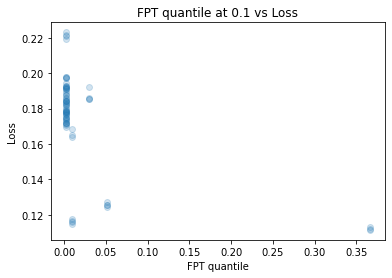

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.45444910352253265, pvalue=4.7562525145329453e-05)
Pearson : (-0.6149436210046948, 5.575614366480567e-09)
R2      : -0.6149436210046948


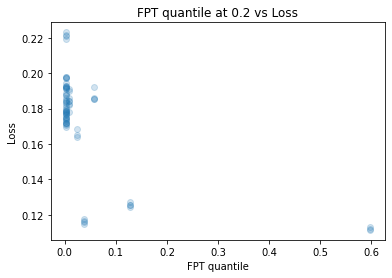

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.5506979515554321, pvalue=3.7035849779278953e-07)
Pearson : (-0.6654869961697437, 9.905551065239098e-11)
R2      : -0.665486996169744


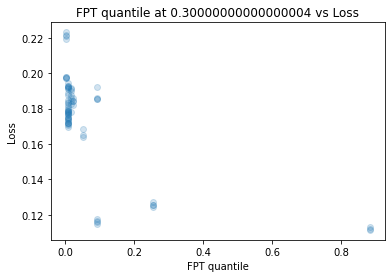

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.5634101217325463, pvalue=1.7313499914319168e-07)
Pearson : (-0.722935050143769, 3.5162164552840526e-13)
R2      : -0.7229350501437689


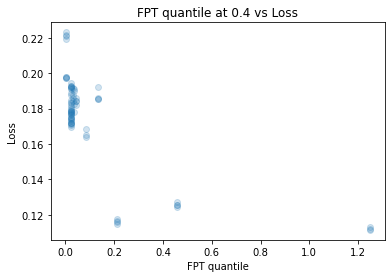

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.6337209961206999, pvalue=1.3587855245712796e-09)
Pearson : (-0.7748421039756643, 5.470368502852181e-16)
R2      : -0.7748421039756644


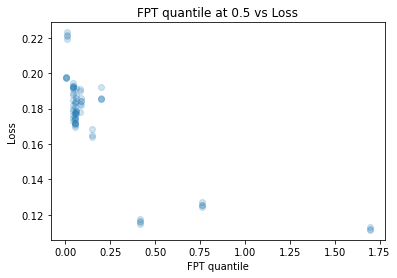

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.7052042977204757, pvalue=2.314279415377195e-12)
Pearson : (-0.8243014678110668, 1.836891484563321e-19)
R2      : -0.8243014678110667


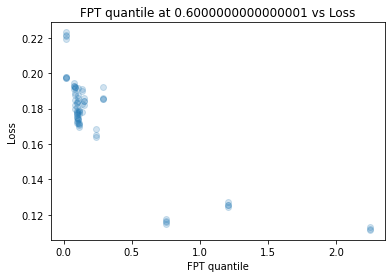

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.7170653730565312, pvalue=6.665759076152907e-13)
Pearson : (-0.867394539001012, 1.6156518508018117e-23)
R2      : -0.867394539001012


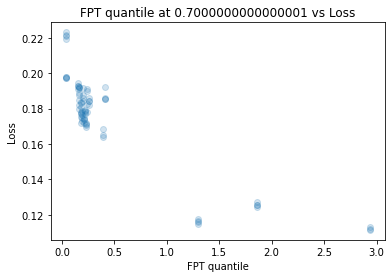

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.7643996437525258, pvalue=2.291858446546101e-15)
Pearson : (-0.9051509320685407, 1.8382648091991073e-28)
R2      : -0.9051509320685407


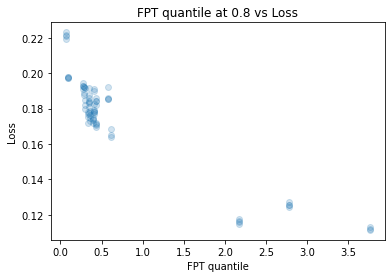

Correlation measures: 
Spearman: SpearmanrResult(correlation=-0.8383937311572949, pvalue=1.1753119006573013e-20)
Pearson : (-0.9354845262968794, 2.9663688057440908e-34)
R2      : -0.9354845262968792


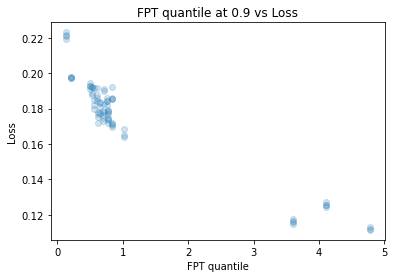

In [79]:
import matplotlib.pyplot as plt
import scipy

for i in range(1,10):
    # Bivariate analysis of quantiles and losses
    x = [x for (x,y) in scatter_data[i]]
    y = [y for (x,y) in scatter_data[i]]
    spearman = scipy.stats.spearmanr(x, y)
    pearson  = scipy.stats.pearsonr(x, y)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print("Correlation measures: ")
    print("Spearman:", spearman )
    print("Pearson :", pearson  )
    print("R2      :", r_value)
    # Plot
    plt.scatter( x, y , alpha=0.2)
    plt.title(f'''FPT quantile at {i*0.1} vs Loss''')
    plt.xlabel("FPT quantile")
    plt.ylabel("Loss")
    plt.show()